# ResNet15 数字为conv和fc（有权重的层）总层数

介绍请见https://myrtle.ai/how-to-train-your-resnet-4-architecture/

## 用到的技巧：

### 数据增强，防止过拟合，增大数据集，可以训练更深的模型，提高预测率
- cutout
- Padding + RandomCrop
- mixup (暂时不用)

### data_loader 
- batch_size为2的幂次方,设置成2的幂性能优化,因为线程数通常是2^n这种数字
- pin_memory=(torch.cuda.is_available()，数据加载，如果有可能，在GPU上完成，提高速率

### nn.CELU代替nn.ReLU
平滑的激活函数对于优化过程也很有帮助

### 标签平滑
标签平滑是提高分类问题中神经网络训练速度和泛化的一个成熟技巧

### 用优化的SGD方法
- SGD小批量，则速度一定比全批量快，在大数据集尤其如此
- momentum 增加动量惯性
- weight_decay 即L2 regularization的系数，正则化
- nesterov = Ture，表示用nesterov momentum

torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 5e-4, nesterov = True)

带有动量的SGD本质：使用指数加权平均之后的梯度代替原梯度进行参数更新。详情请见 https://zhuanlan.zhihu.com/p/62585696

NAG（Nesterov Accelerated Gradient）的本质：多考虑了目标函数的二阶导信息。详情请见 https://zhuanlan.zhihu.com/p/22810533

### epoch设置和learning rate的实时更新
lr 更偏向于先升后降，最开始学习率比较小，中间学习率很高，最后学习率很低很低，最开始是为了预热，也为了防止SGD出现nan。 详情请见：
- 学习率先升后降： https://www.jiqizhixin.com/articles/041905
- 1cycle策略： SGD方法，大学习率（中间）时，momentum较小（0.85），小学习率时，momentum较大（0.95）。这也印证了一个直觉：在训练中，我们希望 SGD 可以迅速调整（大学习率）到搜索平坦区域的方向上，因此就应该对新的梯度赋予更大的权重（momentum相对变小）。 详情请见 https://cloud.tencent.com/developer/article/1118029
- 学习率调整的代码实现（提供包）： https://www.cnblogs.com/wanghui-garcia/p/10895397.html

### 初始化
xavier初始化： 为了使得网络中信息更好的流动，每一层输出的方差应该尽量相等。
He 初始化，专门对relu。这里用了He kaiming初始化
参考： 
- https://zhuanlan.zhihu.com/p/25110150
- https://www.cnblogs.com/darkknightzh/p/8297793.html
- 代码实现： https://www.jianshu.com/p/7a7d45b8e0ee
- 代码实现： https://www.cnblogs.com/Lee-yl/p/10146047.html


### maxpool 在 activation 前面，效果一样，可以节约时间

### Ghost批量归一（暂缺）

归一化（bn）最合适的批量大小大概在32左右。但在批量大小比较大的时候，比如512，降低其大小会严重影响训练时间。不过这一问题可以通过对batch的子集分别进行批量归一来解决，这种方法称为“ghost”批量归一。

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

# 用tensorboard来可视化模型
from tensorboardX import SummaryWriter  # writer就相当于一个日志，保存你要做图的所有信息

# 设置随机数种子
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(20)

In [64]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# Hyper-parameters for updating learning rate
num_epochs = 250
learning_rate = 0.1
batch_size = 256

# lr updating parameters
epochs = [1, 3, 4, 100, 101, 180, 181, 230, 231, num_epochs]
lrs = [learning_rate, 0.2, 0.1, 0.1, 0.01, 0.01, 0.001, 0.001, 0.0001, 0.0001]

In [65]:
# 数据增强方法：1.cutout
class Cutout(object):
    """Randomly mask out one or more patches（补丁，就是一个遮挡小块） from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            # (x,y)表示方形补丁的中心位置
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

# 2.Padding + RandomCrop,用transform自带函数做增强
# 3.mixup也是一种简单的数据增强方法,应用地方是在训练的时候，详见 https://blog.csdn.net/winycg/article/details/88410981
#   beta分布参见 https://www.cnblogs.com/think-and-do/p/6593809.html
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha) # beta分布
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# 4.label_smoothing 标签平滑是提高分类问题中神经网络训练速度和泛化的一个成熟技巧。
# 在Inception论文中提出，对标签label进行增强，作者认为one-hot编码会过拟合，因此作者在交叉熵中对错误label也分配了很小的权重来防止过拟合。
# 作者引入了参数ϵ, 详见 https://blog.csdn.net/winycg/article/details/88410981
# 在label_smoothing之后，loss的数值可能会增大一些，这与acuracy无关
def CrossEntropyLoss_label_smooth(outputs, targets, device,
                                  num_classes=10, epsilon=0.075):
    N = targets.size(0)
    smoothed_labels = torch.full(size=(N, num_classes),
                                 fill_value=epsilon / (num_classes - 1))
    smoothed_labels.scatter_(dim=1, index=torch.unsqueeze(targets.to('cpu'), dim=1),
                             value=1-epsilon)
    smoothed_labels = smoothed_labels.to(device)
    log_prob = nn.functional.log_softmax(outputs, dim=1)
    loss = - torch.sum(log_prob * smoothed_labels) / N
    return loss

In [66]:
# CIFAR-10 dataset
cifar_norm_mean = (0.49139968, 0.48215827, 0.44653124)
cifar_norm_std = (0.24703233, 0.24348505, 0.26158768)

train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                             train=True, 
                                             download=False,
                                             transform=transforms.Compose([
                                                 transforms.Pad(4),     #图像长宽周围都填充4个单位长度（像素）,（32，32）->（40，40）
                                                 transforms.RandomCrop(32),         #随机切割，切割完后的尺寸为32*32
                                                 transforms.RandomHorizontalFlip(),  #对PIL.image水平翻转，默认反转概率0.5
                                                 transforms.ToTensor(),  # totensor要放在这个固定的位置，之前是image，之后是normalize
                                                 transforms.Normalize(cifar_norm_mean, cifar_norm_std),
                                                 Cutout(n_holes=1, length=16),])
                                            )

train_dataset，val_dataset = torch.utils.data.random_split(train_dataset, [45000, 5000])

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=False, 
                                            transform=transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize(cifar_norm_mean, cifar_norm_std)])                                   
                                            )

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,    # 设置成2的幂性能优化,因为线程数通常是2^n这种数字
                                           shuffle=True,
                                           pin_memory=(torch.cuda.is_available()),
                                           )

val_loader = test_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          pin_memory=(torch.cuda.is_available()),
                                          )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          pin_memory=(torch.cuda.is_available()),
                                          )

print(train_dataset,'\n')
print(train_dataset[0][0].shape,'\n')            #第1个数据的X,这里目前由于是ToTensor的结果，是tensor，暂时没有被padding
print(train_dataset[0][1],'\n')            #第1个数据的y
print(train_dataset.targets[0],'\n')       #等同于第1个数据的y

batch=next(iter(train_loader))
images,labels = batch
print(images.shape)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Pad(padding=4, fill=0, padding_mode=constant)
               RandomCrop(size=(32, 32), padding=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.49139968, 0.48215827, 0.44653124), std=(0.24703233, 0.24348505, 0.26158768))
           ) 

torch.Size([3, 32, 32]) 

6 

6 

torch.Size([256, 3, 32, 32])


**pin_memory 理解**
pin_memory就是锁页内存，创建DataLoader时，设置pin_memory=True，则意味着生成的Tensor数据最开始是属于内存中的锁页内存，这样将内存的Tensor转义到GPU的显存就会更快一些。

主机中的内存，有两种存在方式，一是锁页，二是不锁页，锁页内存存放的内容在任何情况下都不会与主机的虚拟内存进行交换（注：虚拟内存就是硬盘），而不锁页内存在主机内存不足时，数据会存放在虚拟内存中。

而显卡中的显存全部是锁页内存！

当计算机的内存充足的时候，可以设置pin_memory=True。当系统卡住，或者交换内存使用过多的时候，设置pin_memory=False。因为pin_memory与电脑硬件性能有关，pytorch开发者不能确保每一个炼丹玩家都有高端设备，因此pin_memory默认为False。

In [67]:
def Conv1(in_planes, places, stride=2): # (3,32,32)
    return nn.Sequential(
        nn.Conv2d(in_channels=in_planes,out_channels=places,kernel_size=7,stride=stride,padding=3, bias=False), #(places,16,16)
        nn.BatchNorm2d(places),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),  # (places,8,8)
        nn.CELU(inplace=True),
    )

class Bottleneck(nn.Module):
    def __init__(self,in_places,places, stride=1,downsampling=False, expansion = 4):
        super(Bottleneck,self).__init__()
        self.expansion = expansion
        self.downsampling = downsampling

        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=in_places,out_channels=places,kernel_size=1,stride=1, bias=False),
            nn.BatchNorm2d(places),
            nn.CELU(inplace=True),
            nn.Conv2d(in_channels=places, out_channels=places, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(places),
            nn.CELU(inplace=True),
            nn.Conv2d(in_channels=places, out_channels=places*self.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(places*self.expansion),
        )

        if self.downsampling:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels=in_places, out_channels=places*self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(places*self.expansion)
            )
        self.celu = nn.CELU(inplace=True)
    def forward(self, x):
        residual = x
        out = self.bottleneck(x)

        if self.downsampling:
            residual = self.downsample(x)

        out += residual
        out = self.celu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, blocks, num_classes=1000, expansion = 4):  # (3,32,32)
        super(ResNet,self).__init__()
        self.expansion = expansion

        self.conv1 = Conv1(in_planes = 3, places= 64)  # (64,8,8)

        self.layer1 = self.make_layer(in_places = 64, places= 64, block=blocks[0], stride=1)   # (256,8,8)
        self.layer2 = self.make_layer(in_places = 256,places=128, block=blocks[1], stride=2)   # (512,4,4)
        self.layer3 = self.make_layer(in_places=512,places=256, block=blocks[2], stride=2)     # (1024,2,2)
        self.layer4 = self.make_layer(in_places=1024,places=512, block=blocks[3], stride=2)    # (2048,1,1)

        #self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(2048,num_classes)
        
        # 初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def make_layer(self, in_places, places, block, stride):
        layers = []
        layers.append(Bottleneck(in_places, places,stride, downsampling =True))
        for i in range(1, block):
            layers.append(Bottleneck(places*self.expansion, places))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
model = ResNet([3, 4, 6, 3], num_classes=10).to(device)

In [69]:
# 保存模型结构
dummy_input = torch.rand(20, 3, 32, 32).to(device)  # 假设输入20张3*32*32的图片
with SummaryWriter(comment='Resnet50') as w:
    w.add_graph(model, (dummy_input,))
    
print('# model parameters:', sum(param.numel() for param in model.parameters()))
    
# 如果要看模型，需要：
# 1.在你的terminal（终端）中 ，在D:\我的代码\jupyter notebook\Programs\CIFAR10\runs 地址下，使用以下命令
# tensorboard --logdir Nov20_21-13-56_LAPTOP-F48B5MHEResnet9
# 2.在浏览器输入
# http://localhost:6006

# model parameters: 23528522


D:\anaconda\envs\pytorch\lib\site-packages\torch\jit\__init__.py:1007: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Not within tolerance rtol=1e-05 atol=1e-05 at input[9, 0] (0.393381267786026 vs. 0.3934645354747772) and 62 other locations (31.00%)
  check_tolerance, _force_outplace, True, _module_class)


In [70]:
# prediction function for simple data
def pred_rate(preds,labels):
    return preds.eq(labels).sum().item()/labels.shape[0]

# prediction function for data loader
def pred_rate_loader(model, val_loader, device):
    model.eval()
    with torch.no_grad():         # 使用 torch,no_grad()构建不需要track的上下文环境，这个时候再不会跟踪track各个tensor的梯度
        correct = 0
        total = 0
        loss = []
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            loss.append(CrossEntropyLoss_label_smooth(outputs, labels, device).cpu().numpy())
            
    model.train()
    return np.mean(loss), correct / total      # 返回loss和pred acc

# For updating learning rate
def piecewise_linear(optimizer, curr_epoch, epochs, lrs):  # 注意,epochs 是list，如[0,40,60],lrs也是list如[0.1,0.3,0],这里从0开始计算
                                                        # 表示1~20epoch时，lr是0~0.4的线性升高，21~60epoch时，lr是0.4~0的线性下降
    length = len(lrs)
    for i in range (length-1):
        if curr_epoch > epochs[i] and curr_epoch < epochs[i+1]:
            lr = lrs[i] + (curr_epoch-epochs[i])/(epochs[i+1]-epochs[i])*(lrs[i+1]-lrs[i])
            break
        elif curr_epoch == epochs[i]:
            lr = lrs[i]
            break
        elif curr_epoch == epochs[-1]:        # 考虑最后一个epoch的特殊情况
            lr = lrs[-1]
            break

    # print
    #if lrs[i] == lrs[i+1]:
        #print('Epoch [{}/{}], learning rate kept still in {}'.format(epoch+1, num_epochs, lr))
    #else:
        #print('Epoch [{}/{}], learning rate updated to {}'.format(epoch+1, num_epochs, lr))
    
    # update lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
    return lr

In [72]:
# Loss and optimizer
# criterion 要写在后面
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9, weight_decay = 5e-4, nesterov = True)

In [73]:
# 画图
loss_ens = []
lr_ens = []
pred_rate_ens = []

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images,labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = CrossEntropyLoss_label_smooth(outputs, labels, device)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 98 == 0:
            curr_loss, curr_acc = pred_rate_loader(model, val_loader, device)
            print ("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Prediction rate: {:.4f}"
                   .format(epoch+1, num_epoches, i+1, total_step, curr_loss, curr_acc))
            
            # 保存数据以画图
            pred_rate_ens.append(curr_acc)
            loss_ens.append(curr_loss)
            
    # update learning rate
    curr_lr = piecewise_linear(optimizer, epoch+1, epochs, lrs)
    # 保存数据以画图
    lr_ens.append(curr_lr)

Epoch [1/250], Step [98/196], Loss: 2.5376, Prediction rate: 0.1758
Epoch [1/250], Step [196/196], Loss: 2.9696, Prediction rate: 0.1625
Epoch [2/250], Step [98/196], Loss: 2.0733, Prediction rate: 0.2070
Epoch [2/250], Step [196/196], Loss: 1.9574, Prediction rate: 0.2875
Epoch [3/250], Step [98/196], Loss: 1.9537, Prediction rate: 0.3086
Epoch [3/250], Step [196/196], Loss: 1.8462, Prediction rate: 0.3125
Epoch [4/250], Step [98/196], Loss: 1.9124, Prediction rate: 0.3438
Epoch [4/250], Step [196/196], Loss: 1.9640, Prediction rate: 0.2500
Epoch [5/250], Step [98/196], Loss: 1.8555, Prediction rate: 0.3750
Epoch [5/250], Step [196/196], Loss: 1.7373, Prediction rate: 0.4125
Epoch [6/250], Step [98/196], Loss: 1.7709, Prediction rate: 0.3828
Epoch [6/250], Step [196/196], Loss: 1.6780, Prediction rate: 0.3500
Epoch [7/250], Step [98/196], Loss: 1.7691, Prediction rate: 0.3750
Epoch [7/250], Step [196/196], Loss: 1.5392, Prediction rate: 0.4750
Epoch [8/250], Step [98/196], Loss: 1.576

Epoch [60/250], Step [196/196], Loss: 1.2475, Prediction rate: 0.6625
Epoch [61/250], Step [98/196], Loss: 1.0825, Prediction rate: 0.6953
Epoch [61/250], Step [196/196], Loss: 1.2797, Prediction rate: 0.6375
Epoch [62/250], Step [98/196], Loss: 1.2091, Prediction rate: 0.6875
Epoch [62/250], Step [196/196], Loss: 1.1985, Prediction rate: 0.6875
Epoch [63/250], Step [98/196], Loss: 1.0820, Prediction rate: 0.7109
Epoch [63/250], Step [196/196], Loss: 1.1379, Prediction rate: 0.6875
Epoch [64/250], Step [98/196], Loss: 1.1183, Prediction rate: 0.6953
Epoch [64/250], Step [196/196], Loss: 1.0782, Prediction rate: 0.7750
Epoch [65/250], Step [98/196], Loss: 1.0133, Prediction rate: 0.7461
Epoch [65/250], Step [196/196], Loss: 1.2218, Prediction rate: 0.6625
Epoch [66/250], Step [98/196], Loss: 1.1207, Prediction rate: 0.7109
Epoch [66/250], Step [196/196], Loss: 1.0605, Prediction rate: 0.7250
Epoch [67/250], Step [98/196], Loss: 1.0623, Prediction rate: 0.7070
Epoch [67/250], Step [196/1

Epoch [119/250], Step [196/196], Loss: 0.8958, Prediction rate: 0.8000
Epoch [120/250], Step [98/196], Loss: 0.8972, Prediction rate: 0.8125
Epoch [120/250], Step [196/196], Loss: 0.8780, Prediction rate: 0.8000
Epoch [121/250], Step [98/196], Loss: 0.8330, Prediction rate: 0.8281
Epoch [121/250], Step [196/196], Loss: 0.9359, Prediction rate: 0.8000
Epoch [122/250], Step [98/196], Loss: 0.8978, Prediction rate: 0.8008
Epoch [122/250], Step [196/196], Loss: 0.7482, Prediction rate: 0.8500
Epoch [123/250], Step [98/196], Loss: 0.8816, Prediction rate: 0.7852
Epoch [123/250], Step [196/196], Loss: 0.8171, Prediction rate: 0.8500
Epoch [124/250], Step [98/196], Loss: 0.8699, Prediction rate: 0.8359
Epoch [124/250], Step [196/196], Loss: 0.7783, Prediction rate: 0.8875
Epoch [125/250], Step [98/196], Loss: 0.7804, Prediction rate: 0.8594
Epoch [125/250], Step [196/196], Loss: 0.8602, Prediction rate: 0.8250
Epoch [126/250], Step [98/196], Loss: 0.8778, Prediction rate: 0.7969
Epoch [126/25

Epoch [178/250], Step [98/196], Loss: 0.8234, Prediction rate: 0.8125
Epoch [178/250], Step [196/196], Loss: 0.9066, Prediction rate: 0.8250
Epoch [179/250], Step [98/196], Loss: 0.8284, Prediction rate: 0.8398
Epoch [179/250], Step [196/196], Loss: 0.8106, Prediction rate: 0.8500
Epoch [180/250], Step [98/196], Loss: 0.8862, Prediction rate: 0.7852
Epoch [180/250], Step [196/196], Loss: 0.8823, Prediction rate: 0.7875
Epoch [181/250], Step [98/196], Loss: 0.7854, Prediction rate: 0.8555
Epoch [181/250], Step [196/196], Loss: 0.8435, Prediction rate: 0.8750
Epoch [182/250], Step [98/196], Loss: 0.7298, Prediction rate: 0.8711
Epoch [182/250], Step [196/196], Loss: 0.6387, Prediction rate: 0.9250
Epoch [183/250], Step [98/196], Loss: 0.7766, Prediction rate: 0.8477
Epoch [183/250], Step [196/196], Loss: 0.6989, Prediction rate: 0.8750
Epoch [184/250], Step [98/196], Loss: 0.7593, Prediction rate: 0.8555
Epoch [184/250], Step [196/196], Loss: 0.8512, Prediction rate: 0.7875
Epoch [185/25

Epoch [236/250], Step [196/196], Loss: 0.6551, Prediction rate: 0.9250
Epoch [237/250], Step [98/196], Loss: 0.6862, Prediction rate: 0.8945
Epoch [237/250], Step [196/196], Loss: 0.6936, Prediction rate: 0.9000
Epoch [238/250], Step [98/196], Loss: 0.7349, Prediction rate: 0.8750
Epoch [238/250], Step [196/196], Loss: 0.6858, Prediction rate: 0.8875
Epoch [239/250], Step [98/196], Loss: 0.6810, Prediction rate: 0.8867
Epoch [239/250], Step [196/196], Loss: 0.6665, Prediction rate: 0.9250
Epoch [240/250], Step [98/196], Loss: 0.7385, Prediction rate: 0.8750
Epoch [240/250], Step [196/196], Loss: 0.7316, Prediction rate: 0.8125
Epoch [241/250], Step [98/196], Loss: 0.6407, Prediction rate: 0.9062
Epoch [241/250], Step [196/196], Loss: 0.6618, Prediction rate: 0.9250
Epoch [242/250], Step [98/196], Loss: 0.7714, Prediction rate: 0.8516
Epoch [242/250], Step [196/196], Loss: 0.6856, Prediction rate: 0.8750
Epoch [243/250], Step [98/196], Loss: 0.7794, Prediction rate: 0.8711
Epoch [243/25

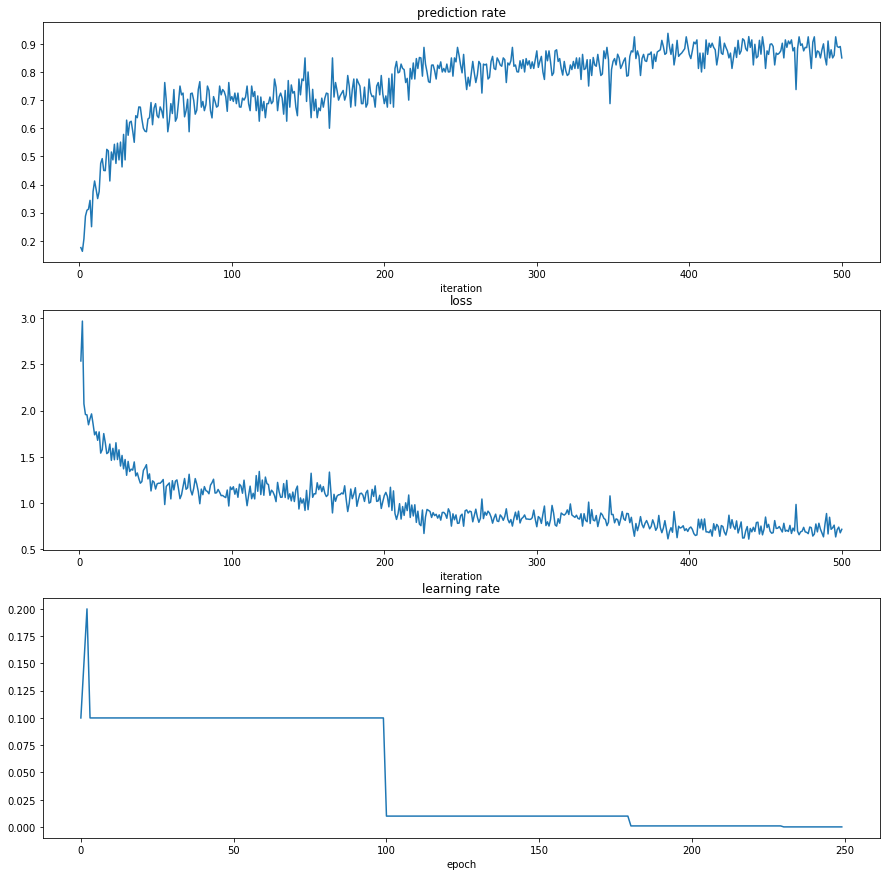

In [78]:
# draw the loss, pred_rate with iteration andd the lr with epoch
plt. figure(figsize=(15,15))

plt.subplot(311)
plt.plot(np.arange(1,len(pred_rate_ens)+1),pred_rate_ens)
plt.title('prediction rate')
plt.xlabel('iteration')

plt.subplot(312)
plt.plot(np.arange(1,len(loss_ens)+1),loss_ens)
plt.title('loss')
plt.xlabel('iteration')

plt.subplot(313)
plt.plot(np.arange(num_epochs),lr_ens)
plt.title('learning rate')
plt.xlabel('epoch')

plt.show()

In [79]:
# Save the model checkpoint，保存的是模型的参数，则保存和读取跟直接保存模型不太一样,但是这个方法成本小
torch.save(model.state_dict(), 'resnet50_piecewise_linear.ckpt')

In [80]:
# Test the model
#model = models.resnet50().to(device)
#model.fc = nn.Linear(512, 10).to(device)  # 层都需要放到device上面

#model.load_state_dict(torch.load('resnet50_piecewise_linear.ckpt'))

model.eval()
with torch.no_grad():         # 使用 torch,no_grad()构建不需要track的上下文环境，这个时候再不会跟踪track各个tensor的梯度
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 89.37 %
